# <a id='toc1_'></a>[X (formerly Twitter) Sentiment Analysis](#toc0_)

Twitter has always been a great source of data for sentiment analysis. I will be using the [sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140) for this EDA. The dataset contains 1.6 million tweets (or X's :D) with labelled sentiment, either positive or negative.

In this notebook, I will try to visualize the dataset to gain as much insight as possible, which will be useful for building a sentiment analysis model later on.

**Table of contents**<a id='toc0_'></a>    
- [X (formerly Twitter) Sentiment Analysis](#toc1_)    
  - [Setting up](#toc1_1_)    
  - [The sentiment140 dataset](#toc1_2_)    
  - [Exploratory Data Analysis](#toc1_3_)    
    - [Quick look](#toc1_3_1_)    
    - [Data cleaning](#toc1_3_2_)    
    - [Word count distribution](#toc1_3_3_)    
    - [Most common users and words](#toc1_3_4_)    
    - [Time for WordClouds](#toc1_3_5_)    
  - [Conclusion](#toc1_4_)    
  - [References](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setting up](#toc0_)

In [1]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

pd.set_option('display.max_colwidth', None)

## <a id='toc1_2_'></a>[The sentiment140 dataset](#toc0_)

The dataset uses a special encoding, and does not include the headers, so we'll manually define them

In [2]:
DATASET_COLUMNS = ['Sentiment', 'Id', 'Date', 'Query', 'User', 'Text']
DATASET_ENCODING = 'ISO-8859-1'

In [3]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
print(f"Shape of the data: {df.shape}")
df.head()

Shape of the data: (1600000, 6)


,Sentiment,Id,Date,Query,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


**We'll re-label the sentiment to make it easier, and also drop the columns irrelevant for analysis**

In [4]:
df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive'})
df.drop(['Id', 'Query'], axis=1, inplace=True)

## <a id='toc1_3_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc1_3_1_'></a>[Quick look](#toc0_)

Let's look at the distribution of sentiment in the dataset and some samples of tweets

In [5]:
df['Sentiment'].value_counts()

Sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64

Looks like the dataset is perfectly balanced, as all things should be. Note that there is no 'Neutral' sentiment in our data, unlike in some other sentiment analysis datasets.

In [6]:
# Some positive tweets
df.query('Sentiment == "Positive"').head(20)

,Sentiment,Date,User,Text
800000,Positive,Mon Apr 06 22:22:45 PDT 2009,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,Positive,Mon Apr 06 22:22:45 PDT 2009,becca210,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800002,Positive,Mon Apr 06 22:22:46 PDT 2009,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800003,Positive,Mon Apr 06 22:22:46 PDT 2009,katarinka,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800004,Positive,Mon Apr 06 22:22:46 PDT 2009,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
800005,Positive,Mon Apr 06 22:22:47 PDT 2009,ajarofalmonds,@ProductOfFear You can tell him that I just burst out laughing really loud because of that Thanks for making me come out of my sulk!
800006,Positive,Mon Apr 06 22:22:51 PDT 2009,vmdavinci,@r_keith_hill Thans for your response. Ihad already find this answer
800007,Positive,Mon Apr 06 22:22:48 PDT 2009,jessicavaliyi,"@KeepinUpWKris I am so jealous, hope you had a great time in vegas! how did you like the ACM's?! LOVE YOUR SHOW!!"
800008,Positive,Mon Apr 06 22:22:49 PDT 2009,emmasaur28,"@tommcfly ah, congrats mr fletcher for finally joining twitter"
800009,Positive,Mon Apr 06 22:22:49 PDT 2009,SherylBreuker,@e4VoIP I RESPONDED Stupid cat is helping me type. Forgive errors


In [7]:
# Some negative tweets
df.query('Sentiment == "Negative"').head(20)

,Sentiment,Date,User,Text
0,Negative,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,Negative,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew
6,Negative,Mon Apr 06 22:20:03 PDT 2009,mybirch,Need a hug
7,Negative,Mon Apr 06 22:20:03 PDT 2009,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,Negative,Mon Apr 06 22:20:05 PDT 2009,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,Negative,Mon Apr 06 22:20:09 PDT 2009,mimismo,@twittera que me muera ?


### <a id='toc1_3_2_'></a>[Data cleaning](#toc0_)

We'll start with cleaning the corpus, which helps with extracting more meaningful information later. We'll clean the tweets by removing mentions, punctuations and URLs. We'll also remove stopwords and lemmatize the words.

Word count column will be created as well since it is a useful meta-feature.

In [8]:
stopwords_en = set(stopwords.words('english')) | STOPWORDS
wnl = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    words = [wnl.lemmatize(word) for word in text.split() if word not in stopwords_en]
    text = ' '.join(words)

    text = re.sub('@\[A-Za-z0-9\]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
df['Text'] = df['Text'].apply(clean_text)
df['Wordcount'] = df['Text'].str.split().apply(len)

positive = df.query('Sentiment == "Positive"')
negative = df.query('Sentiment == "Negative"')

### <a id='toc1_3_3_'></a>[Word count distribution](#toc0_)
Plotting the distribution word counts for each sentiment. I'm using countplots even though it doesn't look the best, since histograms doesn't work well out of the box with a lot of data with low variance.

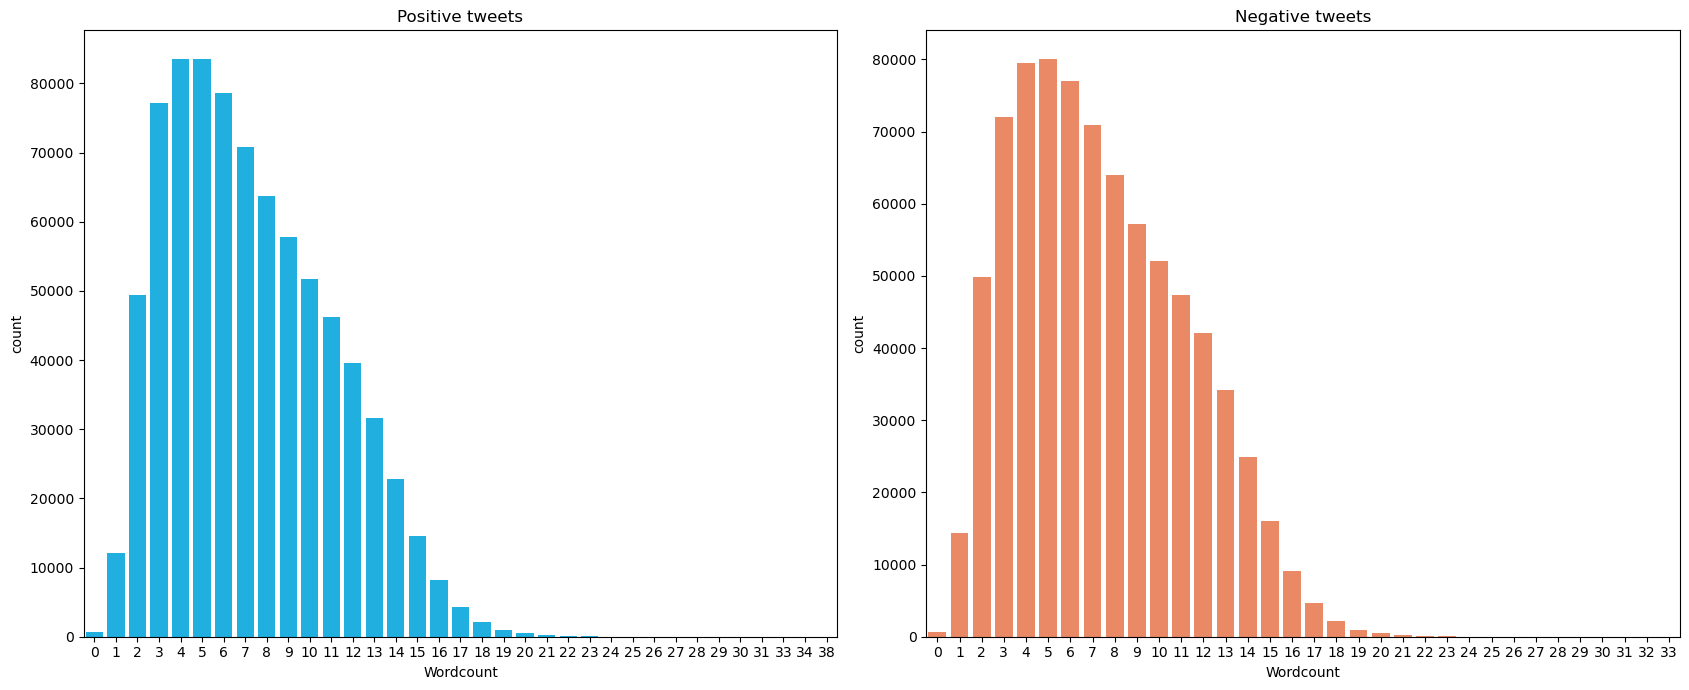

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

axes[0].set_title('Positive tweets')
axes[1].set_title('Negative tweets')
sns.countplot(x=positive['Wordcount'], color='deepskyblue', ax=axes[0])
sns.countplot(x=negative['Wordcount'], color='coral', ax=axes[1])

plt.tight_layout()

Interestingly, the number of words for positive and negative are almost the same, where very few tweets are longer than 20 words. Thus, the word count distributions are right skewed.

<Axes: title={'center': 'KDE plot for Wordcount'}, xlabel='Wordcount', ylabel='Density'>

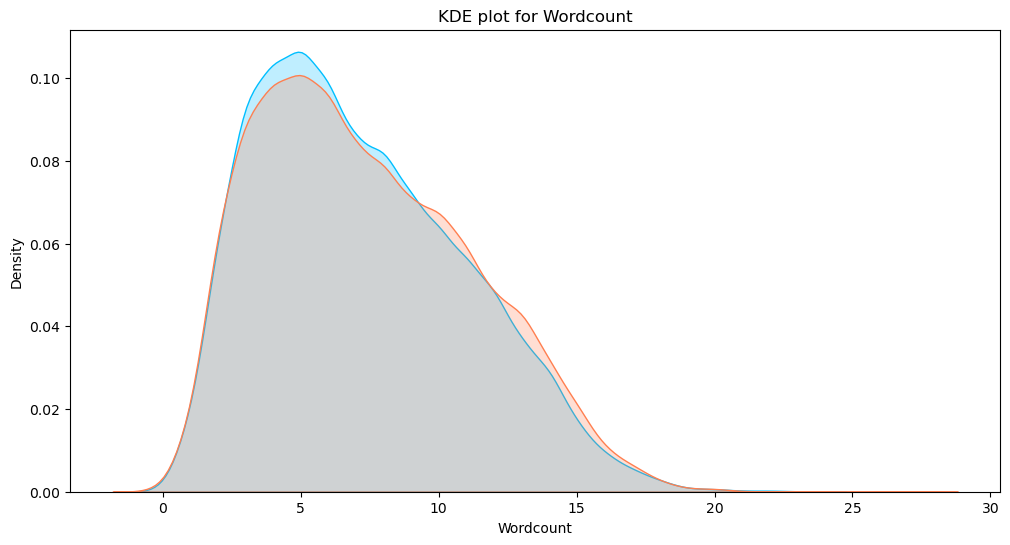

In [11]:
plt.figure(figsize=(12, 6))
plt.title('KDE plot for Wordcount')

sns.kdeplot(x=positive['Wordcount'].sample(10000), fill=True, color='deepskyblue')
sns.kdeplot(x=negative['Wordcount'].sample(10000), fill=True, color='coral')

Again, KDE plot confirms the findings, but it doesn't work nicely with too much data points so I only used a subset of the data 

### <a id='toc1_3_4_'></a>[Most common users and words](#toc0_)

In [12]:
# Top 20 users with most tweets
tmp = pd.DataFrame(df['User'].value_counts().head(20))
tmp.style.background_gradient(cmap='Blues')

,count
User,
lost_dog,549
webwoke,345
tweetpet,310
SallytheShizzle,281
VioletsCRUK,279
mcraddictal,276
tsarnick,248
what_bugs_u,246
Karen230683,238


User data might not be too useful here, so we move on

Now what are the most common words for each category?

In [13]:
positive_words = positive['Text'].str.split()
negative_words = negative['Text'].str.split()

top_pos = Counter([word for text in positive_words for word in text])
top_pos_df = pd.DataFrame(top_pos.most_common(20), columns=['Words', 'Counts'])

top_neg = Counter([word for text in negative_words for word in text])
top_neg_df = pd.DataFrame(top_neg.most_common(20), columns=['Words', 'Counts'])

<Axes: title={'center': 'Most Frequent words in Negative tweets'}, xlabel='Counts', ylabel='Words'>

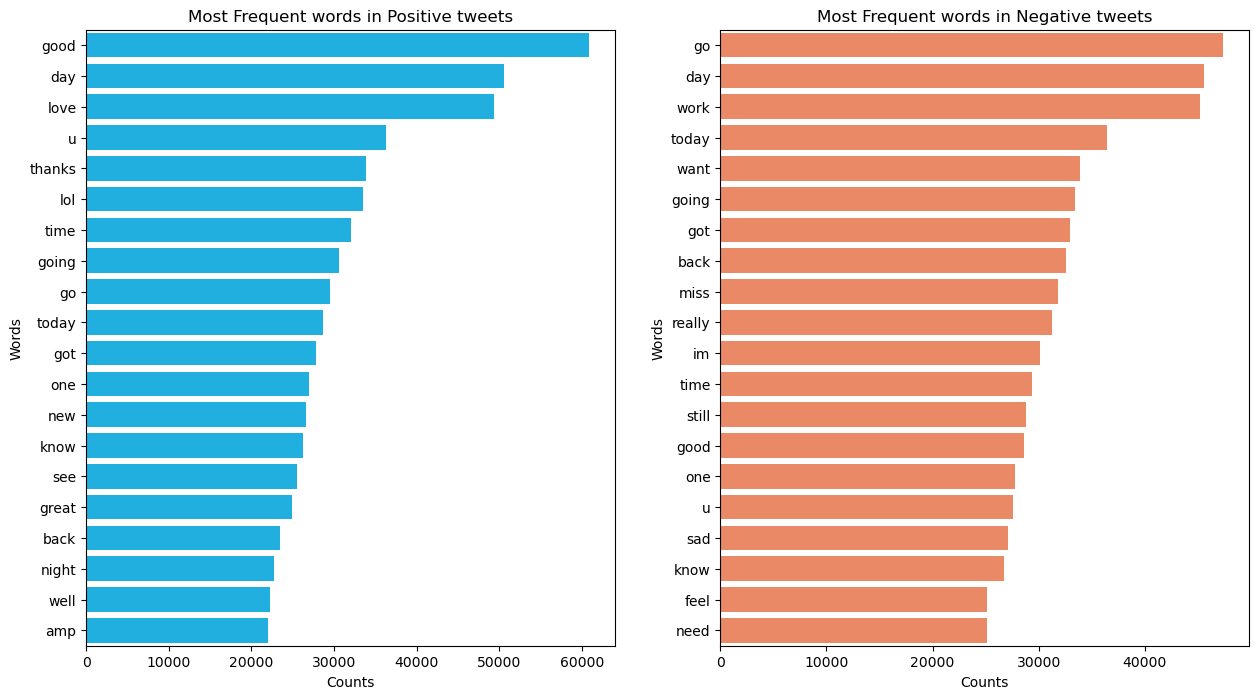

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")

sns.barplot(top_pos_df, y='Words', x='Counts', color='deepskyblue', ax=ax[0])
sns.barplot(top_neg_df, y='Words', x='Counts', color='coral', ax=ax[1])

This might not be too useful since many of them are still common English words. Instead, we can look at the most common words that are **unique** in each sentiment. (Actually, we will show words that are not strictly unique but appear little in the opposite sentiment)

In [15]:
threshold = 0.001 * len(positive)

unique_pos = Counter([word for text in positive_words for word in text if top_neg.get(word, 0) < threshold])
unique_pos_df = pd.DataFrame(unique_pos.most_common(20), columns=['Words', 'Counts'])

unique_neg = Counter([word for text in negative_words for word in text if top_pos.get(word, 0) < threshold])
unique_neg_df = pd.DataFrame(unique_neg.most_common(20), columns=['Words', 'Counts'])

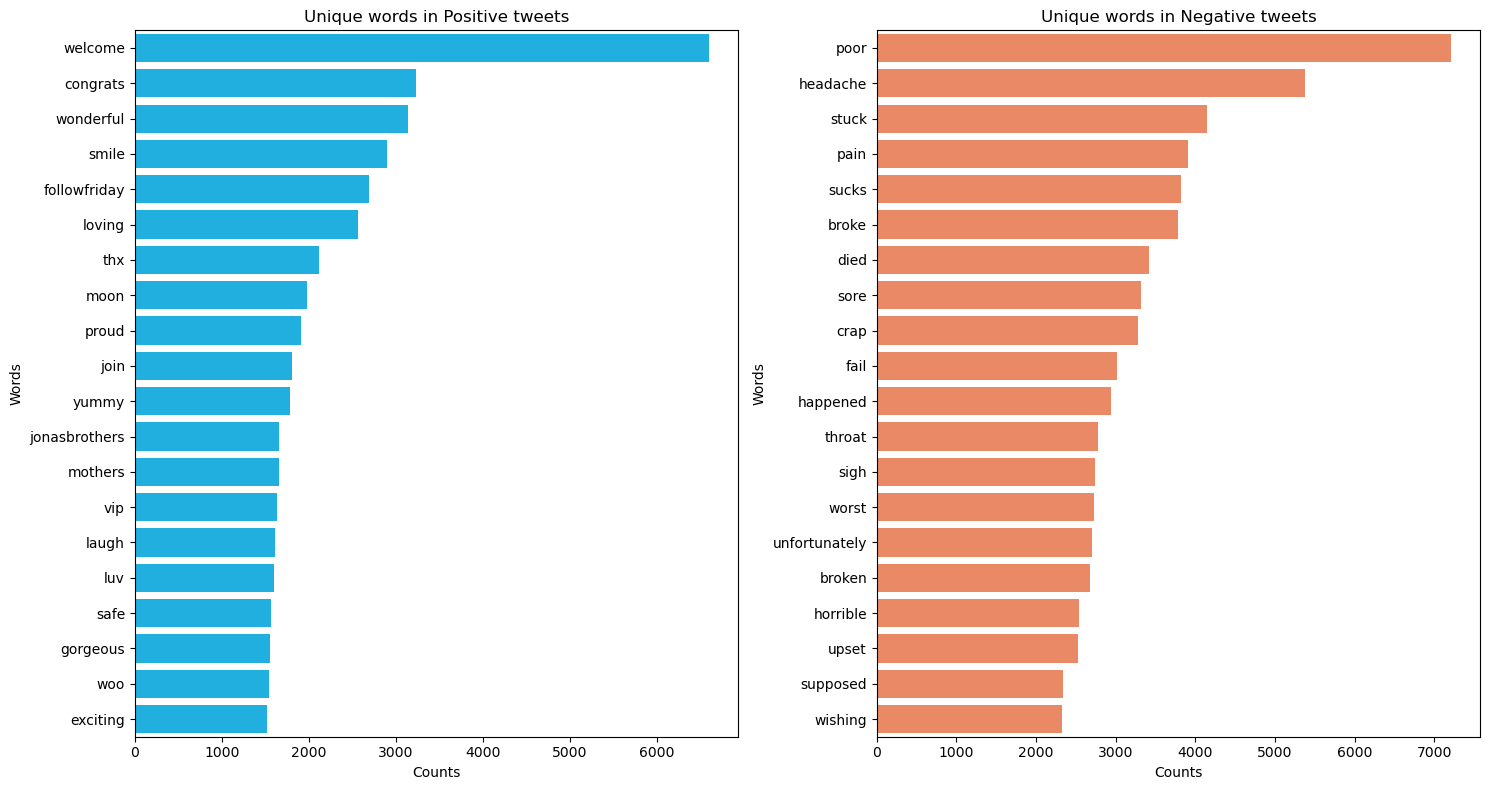

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Unique words in Positive tweets")
ax[1].set_title("Unique words in Negative tweets")

sns.barplot(unique_pos_df, y='Words', x='Counts', color='deepskyblue', ax=ax[0])
sns.barplot(unique_neg_df, y='Words', x='Counts', color='coral', ax=ax[1])

plt.tight_layout()

By looking at the unique words of each sentiment, we now have much more clarity about the data. These unique words are very strong determiners of the sentiment!

### <a id='toc1_3_5_'></a>[Time for WordClouds](#toc0_)

WordClouds might not be the most useful visualizations, but they sure are fun to look at to end our EDA

In [17]:
def word_cloud(array, add_stopwords):
    texts = ' '.join(text for text in array)
    stopwords = set(STOPWORDS)
    stopwords = stopwords.union(add_stopwords)
    wordcloud = WordCloud(width=800, height=800, 
                    background_color='white', 
                    stopwords=stopwords, 
                    min_font_size=10).generate(texts)

    plt.figure(figsize=(15, 8), facecolor=None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad=0) 

    plt.show()
    
extra_stopwords = {'ti', 'ame', 'amp', 'quot', 'lol', 'one'}

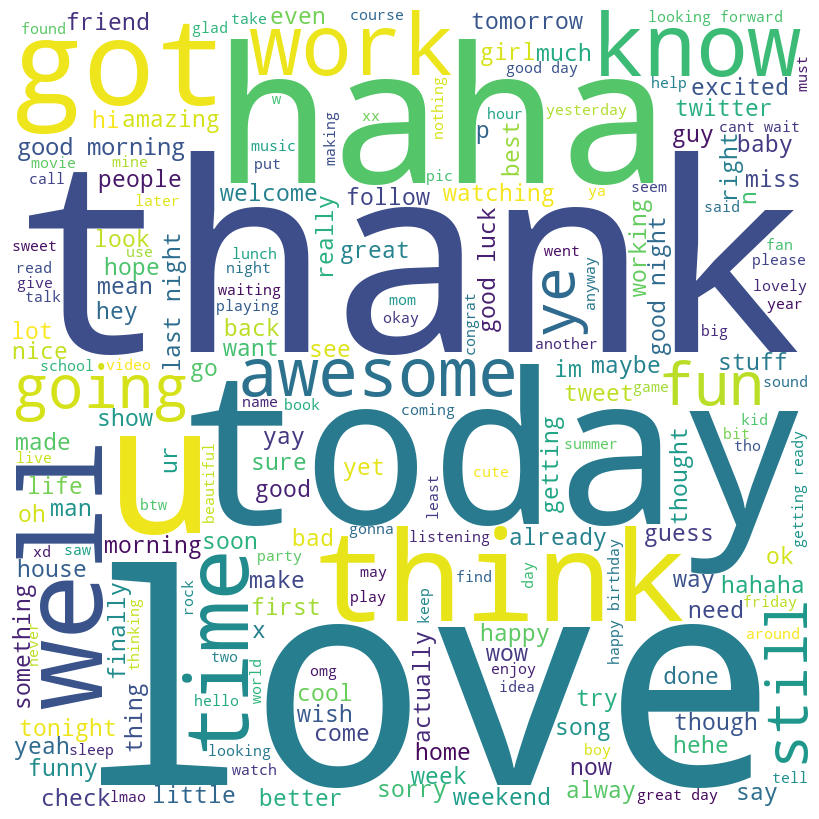

In [18]:
word_cloud(positive['Text'], extra_stopwords)

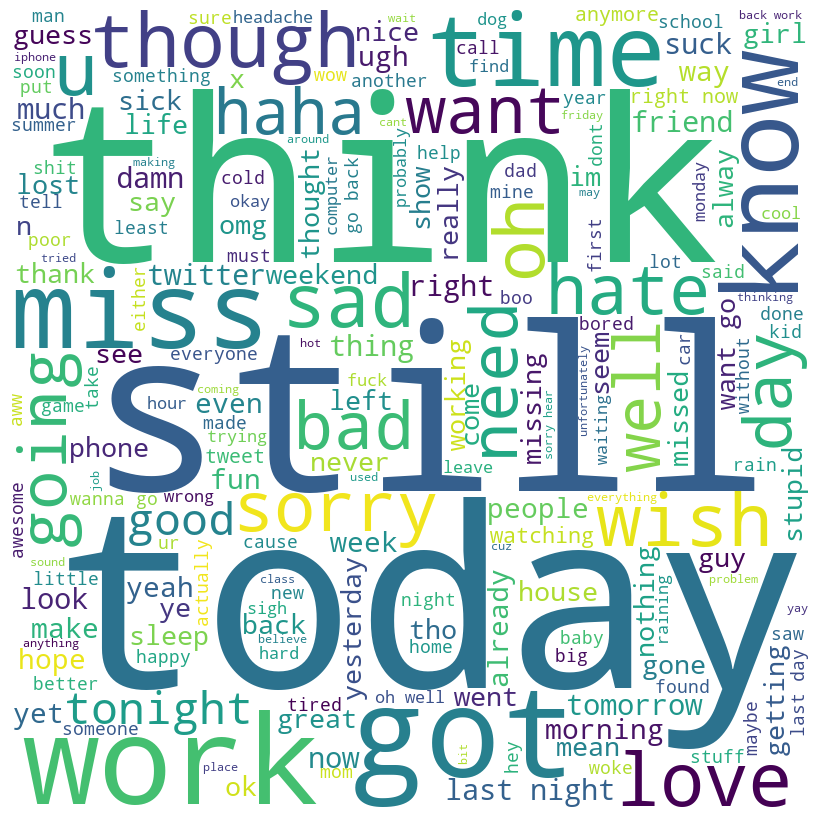

In [19]:
word_cloud(negative['Text'], extra_stopwords)

## <a id='toc1_4_'></a>[Conclusion](#toc0_)

This is probably one of my first exposure with EDA for text data. Hope it was not too bad and I would definitely love learn more about NLP in the future!

## <a id='toc1_5_'></a>[References](#toc0_)

- https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model/
- https://github.com/yogeshwaran-shanmuganathan/Twitter-Sentiment-Analysis/